## <center>Conditional WGAN with Gradient Penality</center>

Import tensorflow and enable eager execution mode. Also check GPU availability

In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
print("You are using tensorflow version "+str(tf.__version__)+" in eager-execution mode")

You are using tensorflow version 2.9.1 in eager-execution mode


In [2]:
print("Checking for GPU availability...")
if tf.test.is_gpu_available():
    print("--> Valid GPU of type "+str(tf.test.gpu_device_type())+" with name "+tf.test.gpu_device_name()+" found!")
else:
    print("--> No GPU detected!")

Checking for GPU availability...
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
--> No GPU detected!


In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from IPython import display

### Import dataset

In [4]:
(train_x, train_y), (_, _) = tf.keras.datasets.mnist.load_data()

### Preprocess the dataset

In [5]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x = (train_x - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [6]:
BUFFER_SIZE = 60000
IMG_WIDTH = 28
IMG_HEIGHT = 28
IMG_CHANNEL = 1
n_classes = 10
BATCH_SIZE = 300 # 256
LAMBDA = 10 # For gradient penalty
N_CRITIC = 3 # Train critic(discriminator) n times then train generator 1 time.

noise_dim = 100
EPOCHS = 50
num_examples_to_generate = 16

In [7]:
one_hot_labels = tf.one_hot(train_y, n_classes)

image_one_hot_labels = one_hot_labels[:, :, None, None]
image_one_hot_labels = tf.repeat(image_one_hot_labels, repeats=[IMG_WIDTH * IMG_HEIGHT])
image_one_hot_labels = tf.reshape(image_one_hot_labels, (-1, IMG_WIDTH, IMG_HEIGHT, n_classes))
image_one_hot_labels.shape

TensorShape([60000, 28, 28, 10])

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((train_x, one_hot_labels, image_one_hot_labels))
dataset = dataset.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE)

Shape of training images: (60000, 28, 28, 1)
Shape of training labels: (60000, 10)
Example: 
4


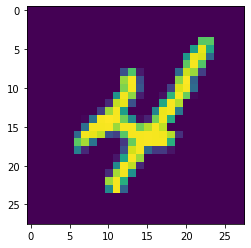

In [9]:
print(f"Shape of training images: {train_x.shape}")
print(f"Shape of training labels: {one_hot_labels.shape}")
print("Example: ")
plt.imshow(train_x[9])
print(train_y[9])

### Create the models

In [10]:
def make_generator_model(gen_input_dim):
    
    gen_input_img = tf.keras.Input(shape=(gen_input_dim), batch_size=BATCH_SIZE)
    dense_0 = tf.keras.layers.Dense(7*7*gen_input_dim, use_bias=False, input_shape=(gen_input_dim,))(gen_input_img)
    bt_norm_0 = tf.keras.layers.BatchNormalization()(dense_0)
    leaky_0 = tf.keras.layers.LeakyReLU()(bt_norm_0)
    
    reshaped_0 = tf.keras.layers.Reshape((7,7,gen_input_dim))(leaky_0)

    assert reshaped_0.shape == (BATCH_SIZE,7,7,gen_input_dim)
    
    conv2dT_0 = tf.keras.layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False)(reshaped_0)
    assert conv2dT_0.shape == (BATCH_SIZE,7,7,128)
    bt_norm_1 = tf.keras.layers.BatchNormalization()(conv2dT_0)
    leaky_1 = tf.keras.layers.LeakyReLU()(bt_norm_1)
    
    ###############
    conv2dT_0_0 = tf.keras.layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False)(leaky_1)
    assert conv2dT_0_0.shape == (BATCH_SIZE,7,7,128)
    bt_norm_1_1 = tf.keras.layers.BatchNormalization()(conv2dT_0_0)
    leaky_1_1 = tf.keras.layers.LeakyReLU()(bt_norm_1_1)
    ###############
    
    conv2dT_1 = tf.keras.layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False)(leaky_1_1)
    assert conv2dT_1.shape == (BATCH_SIZE,14,14,64)
    bt_norm_2 = tf.keras.layers.BatchNormalization()(conv2dT_1)
    leaky_2 = tf.keras.layers.LeakyReLU()(bt_norm_2)
    
    output_img = tf.keras.layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False)(leaky_2)
    assert output_img.shape == (BATCH_SIZE, IMG_WIDTH, IMG_HEIGHT, 1)
    
    model = tf.keras.Model(inputs=gen_input_img, outputs=output_img)
    
    return model

In [11]:
def make_discriminator_model(discriminator_in_channels):
    disc_input_img = tf.keras.Input(shape=(IMG_WIDTH,IMG_HEIGHT,discriminator_in_channels), batch_size=BATCH_SIZE)
    conv2d_0 = tf.keras.layers.Conv2D(64, (5,5), strides=(2,2), padding='same',
                                     input_shape=[IMG_WIDTH, IMG_HEIGHT, discriminator_in_channels])(disc_input_img)
    leaky_0 = tf.keras.layers.LeakyReLU()(conv2d_0)
    drop_0 = tf.keras.layers.Dropout(0.3)(leaky_0)
    
    conv2d_1 = tf.keras.layers.Conv2D(128, (5,5), strides=(2,2), padding='same')(drop_0)
    leaky_1 = tf.keras.layers.LeakyReLU()(conv2d_1)
    drop_1 = tf.keras.layers.Dropout(0.3)(leaky_1)
    
    ##########
    conv2d_1_1 = tf.keras.layers.Conv2D(128, (5,5), strides=(2,2), padding='same')(drop_1)
    leaky_1_1 = tf.keras.layers.LeakyReLU()(conv2d_1_1)
    drop_1_1 = tf.keras.layers.Dropout(0.3)(leaky_1_1)
    ##########
    
    flatten_0 = tf.keras.layers.Flatten()(drop_1)
    dense_0 = tf.keras.layers.Dense(1)(flatten_0)
    
    model = tf.keras.Model(inputs=disc_input_img, outputs=dense_0)
    
    return model

#### You need to create a function that will be used to concat two vectors like the noise and the one_hot vectors to be feed to the generator and/or the generated_image's channels with the one_hot vector and/or the real_images's channels with the one_hot vector

In [12]:
def combine_vectors(x, y, axis=-1):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector. 
        In this assignment, this will be the noise vector of shape (n_samples, z_dim), 
        but you shouldn't need to know the second dimension's size.
      y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector 
        with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    # Note: Make sure this function outputs a float no matter what inputs it receives
    combined = tf.concat((x,y), axis)
    return combined

In [13]:
def get_input_dimensions(z_dim, mnist_shape, n_classes):
    '''
    Function for getting the size of the conditional input dimensions 
    from z_dim, the image shape, and number of classes.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        mnist_shape: the shape of each MNIST image as (C, W, H), which is (1, 28, 28)
        n_classes: the total number of classes in the dataset, an integer scalar
                (10 for MNIST)
    Returns: 
        generator_input_dim: the input dimensionality of the conditional generator, 
                          which takes the noise and class vectors
        discriminator_im_chan: the number of input channels to the discriminator
                            (e.g. C x 28 x 28 for MNIST)
    '''
    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = mnist_shape[2] + n_classes
    
    return generator_input_dim, discriminator_im_chan

### Now test the Gen and Disc input/output images

In [14]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(noise_dim, 
                                                                  (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNEL), 
                                                                  n_classes)
generator_input_dim, discriminator_im_chan

(110, 11)

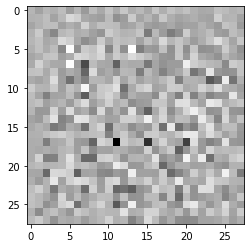

In [15]:
generator = make_generator_model(generator_input_dim)
# generator.summary()

noise = tf.random.normal([1, generator_input_dim]) # Note 1 is the batch size i.e. for testing
test_generated_image = generator(noise, training=False)
plt.imshow(test_generated_image[0, :, :, 0], cmap='gray')

In [16]:
discriminator = make_discriminator_model(discriminator_im_chan)
# discriminator.summary()

# Before you pass the generator_output to the discriminator, you need to add the channel number which is 1 in the output
# with the n_classes that you have set previously
image_one_hot_labels_test = one_hot_labels[0, :, None, None]
image_one_hot_labels_test = tf.repeat(image_one_hot_labels_test, repeats=[IMG_WIDTH * IMG_HEIGHT])
image_one_hot_labels_test = tf.reshape(image_one_hot_labels_test, (-1, IMG_WIDTH, IMG_HEIGHT, n_classes))

disc_input_img_test = combine_vectors(test_generated_image, image_one_hot_labels_test)


test_decision = discriminator(disc_input_img_test)
print(test_decision)

tf.Tensor([[0.29644892]], shape=(1, 1), dtype=float32)


## Define optimizers

Define loss functions and optimizers for both models.


In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints

In [18]:
generator = make_generator_model(generator_input_dim)
discriminator = make_discriminator_model(discriminator_im_chan)


ckpt_dir = 'training_ckpts'
ckpt_prefix = os.path.join(ckpt_dir, 'ckpt')
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                          discriminator_optimizer=discriminator_optimizer,
                          generator=generator,
                          discriminator=discriminator)

In [19]:
@tf.function
def train_g_step(images, labels, image_one_hot_labels):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    noise_and_labels = combine_vectors(noise, labels)
    # print("Gen input_shape = "+str(noise_and_labels.shape))
    
    with tf.GradientTape(persistent=True) as g_tape:
        generated_image = generator(noise_and_labels, training=True)
        generated_image_and_labels = combine_vectors(generated_image, image_one_hot_labels)
        generated_pred = discriminator(generated_image_and_labels, training=True)
        # Calculate the loss
        G_loss = -tf.reduce_mean(generated_pred)
        
    # Calculate the gradient
    G_grad = g_tape.gradient(G_loss, generator.trainable_variables)
    # Apply gradient
    generator_optimizer.apply_gradients(zip(G_grad, generator.trainable_variables))
    
    # Return the loss
    return G_loss
            

In [20]:
@tf.function
def train_d_step(images, labels, image_one_hot_labels):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    noise_and_labels = combine_vectors(noise, labels)
    
    images_and_labels = combine_vectors(images, image_one_hot_labels)
    
    epsilon = tf.random.uniform(shape=[BATCH_SIZE, 1, 1, 1], minval=0, maxval=1)
    
    with tf.GradientTape(persistent=True) as d_tape:
        with tf.GradientTape() as gp_tape:
            generated_image = generator(noise_and_labels, training=True)
            generated_image_and_labels = combine_vectors(generated_image, image_one_hot_labels)
            interpolated_image = epsilon * tf.dtypes.cast(images_and_labels, tf.float32) + ((1 - epsilon) * generated_image_and_labels)
            #interpolated_image_and_labels = combine_vectors(interpolated_image, image_one_hot_labels)
            interpolated_pred = discriminator(interpolated_image, training=True) #interpolated_image_and_labels
            
        # Compute the gradient penality
        grads = gp_tape.gradient(interpolated_pred, interpolated_image) #interpolated_image_and_labels
        grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean(tf.square(grad_norms - 1))
        
        generated_pred = discriminator(generated_image_and_labels, training=True)
        real_pred = discriminator(images_and_labels, training=True)
        
        # Calculate the D_loss
        D_loss = tf.reduce_mean(generated_pred) - tf.reduce_mean(real_pred) + LAMBDA * gradient_penalty
    
    # Calculate the gradient
    D_grad = d_tape.gradient(D_loss, discriminator.trainable_variables)
    # Apply the gradients to the optimizer
    discriminator_optimizer.apply_gradients(zip(D_grad, discriminator.trainable_variables))
       
    return D_loss

In [21]:
# This is used for visualizing how well your generator model is generating for num_of_examples_to_generate
def seeder(labels):
    seed_with_one_hot = combine_vectors(tf.random.normal([num_examples_to_generate, noise_dim]), 
                                    labels[:num_examples_to_generate])
    return seed_with_one_hot

In [22]:
generator_losses = []
discriminator_losses = []
gen_mean = []
disc_mean = []
display_step = 10


def train(dataset, epochs):
    n_critic_count = 0
    
    for epoch in range(epochs):
        start = time.time()
        
        for step, (image_batch, labels, image_one_hot_labels) in enumerate(dataset):
            
            # Train the critic/discriminator
            D_loss = train_d_step(image_batch, labels, image_one_hot_labels)
            
            n_critic_count += 1
            if n_critic_count >= N_CRITIC:
                
                # Keep track of the only the last discriminator losses to make it equal length with the generator
                discriminator_losses.append(D_loss)
                
                # Train the generator per N_CRITIC discriminator train steps
                G_loss = train_g_step(image_batch, labels, image_one_hot_labels)
                # Keep track of the generator losses
                generator_losses.append(G_loss)
                n_critic_count = 0
                
            # Visualization and loss tracking
            if step % display_step == 0 and step > 0:
                loss_plotter(generator_losses, discriminator_losses, step, display_step, epoch)
                generate_and_save_images(generator,
                                     image_batch,
                                     epoch + 1,
                                     seeder(labels),
                                     real=False)
                generate_and_save_images(None,
                                     image_batch,
                                     None,
                                     None, 
                                     real=True)
            
        # Produce images for GIF as you train
        #display.clear_output(wait=True)
        '''
        generate_and_save_images(generator,
                                 image_batch,
                                 epoch + 1,
                                seed)
        '''
        # Save model every 15 epochs
        if (epoch + 1) % 15 == 0:
            ckpt.save(file_prefix = ckpt_prefix)
            
        print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))
        
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             image_batch,
                             epochs,
                             seed)

In [23]:
def loss_plotter(generator_losses, discriminator_losses, cur_step, display_step, epoch):
    gen_mean_s = sum(generator_losses[-display_step:]) / display_step
    disc_mean_s = sum(discriminator_losses[-display_step:]) / display_step
    print(f"Step {cur_step}: Generator loss: {gen_mean_s}, discriminator loss: {disc_mean_s}")
    gen_mean.append(gen_mean_s)
    disc_mean.append(disc_mean_s)
    plt.plot(gen_mean, color='blue', label="Generator Loss")
    plt.plot(disc_mean, color='red', label="Discriminator Loss")
    plt.legend()
    plt.show()

In [24]:
def generate_and_save_images(model, image_batch, epoch, test_seed_with_one_hot, real=False):
    if real == False:
        # You have to set training = False, because it is inference
        predictions = model(test_seed_with_one_hot, training=False)

        fig = plt.figure(figsize=(4,4))

        for i in range(num_examples_to_generate):

            plt.subplot(4,4,i+1, label='Predicted')
            plt.imshow(predictions[i,:,:,0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')

        plt.savefig('epoch_images/image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()
    else:
        fig = plt.figure(figsize=(4,4))

        for i in range(num_examples_to_generate):

            plt.subplot(4,4,i+1, label='Real')
            plt.imshow(image_batch[i,:,:,0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')

        plt.show()

In [25]:
ckpt.restore(tf.train.latest_checkpoint(ckpt_dir))

Step 10: Generator loss: 12.385568618774414, discriminator loss: -0.5808348655700684


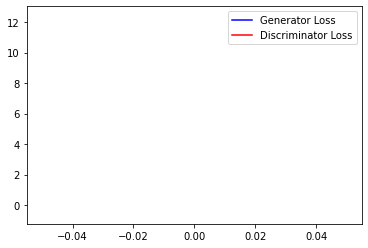

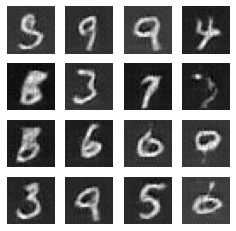

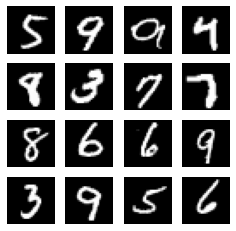

Step 20: Generator loss: 29.10733413696289, discriminator loss: -1.3349378108978271


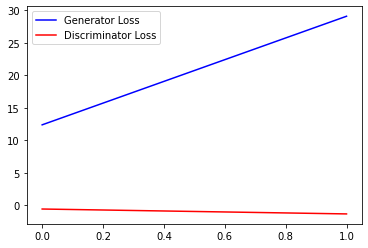

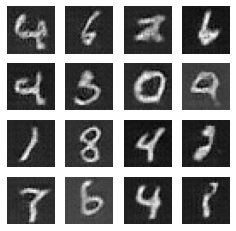

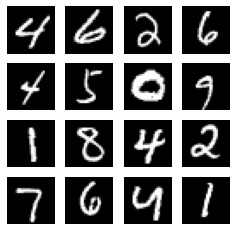

KeyboardInterrupt: 

In [26]:
train(dataset, EPOCHS)

### Create GIF

In [29]:
def display_image(epoch_no):
    return PIL.Image.open('epoch_images/image_at_epoch_{:04d}.png'.format(1))

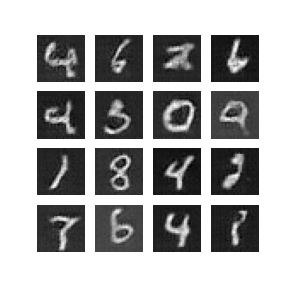

In [30]:
display_image(200)

Use imageio to create an animated gif using the images saved during training.

In [32]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('epoch_images/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [33]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

ModuleNotFoundError: No module named 'tensorflow_docs'